# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,"TRUMP ROCKS MASSIVE PENSACOLA, FL RALLY: “The ...","It is so great to be back in Florida, my secon...",politics,"Sep 9, 2016",fake
1,FBI AGENT Who ‘Found Nothing’ on Huma and Anth...,Holy moly! We ve been covering the FBI agent w...,Government News,"Dec 4, 2017",fake
2,WV Republican AG Spokeswoman BUSTED Appearing...,You know what s adorable? When a white suprema...,News,"August 26, 2016",fake
3,EU affirms support for Lebanon stability,BEIRUT (Reuters) - The European Union on Wedne...,worldnews,"November 8, 2017",true
4,A TAMPON TAX? Women Suing Their State For Unfa...,This is proof that the government will tax jus...,Government News,"Mar 3, 2016",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"TRUMP ROCKS MASSIVE PENSACOLA, FL RALLY: “The ...","It is so great to be back in Florida, my secon...",politics,fake
1,FBI AGENT Who ‘Found Nothing’ on Huma and Anth...,Holy moly! We ve been covering the FBI agent w...,Government News,fake
2,WV Republican AG Spokeswoman BUSTED Appearing...,You know what s adorable? When a white suprema...,News,fake
3,EU affirms support for Lebanon stability,BEIRUT (Reuters) - The European Union on Wedne...,worldnews,true
4,A TAMPON TAX? Women Suing Their State For Unfa...,This is proof that the government will tax jus...,Government News,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,"It is so great to be back in Florida, my secon...",politics,fake
1,Holy moly! We ve been covering the FBI agent w...,Government News,fake
2,You know what s adorable? When a white suprema...,News,fake
3,BEIRUT (Reuters) - The European Union on Wedne...,worldnews,true
4,This is proof that the government will tax jus...,Government News,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,"it is so great to be back in florida, my secon...",politics,fake
1,holy moly! we ve been covering the fbi agent w...,Government News,fake
2,you know what s adorable? when a white suprema...,News,fake
3,beirut (reuters) - the european union on wedne...,worldnews,true
4,this is proof that the government will tax jus...,Government News,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,it is so great to be back in florida my second...,politics,fake
1,holy moly we ve been covering the fbi agent wh...,Government News,fake
2,you know what s adorable when a white supremac...,News,fake
3,beirut reuters the european union on wednesda...,worldnews,true
4,this is proof that the government will tax jus...,Government News,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\ADITI
[nltk_data]     ANIL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,great back florida second home let also thank ...,politics,fake
1,holy moly covering fbi agent fired antitrump t...,Government News,fake
2,know adorable white supremacist christian atte...,News,fake
3,beirut reuters european union wednesday said r...,worldnews,true
4,proof government tax anything calling tampons ...,Government News,fake


**TF-IDF stands for “Term Frequency – Inverse Document Frequency ”**

* TF-IDF is a numerical statistic which measures the importance of the word in a document.

* Term Frequency : Number of time a word appears in a text document.
* Inverse Document Frequency : Measure the word is a rare word or common word in a document.

## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


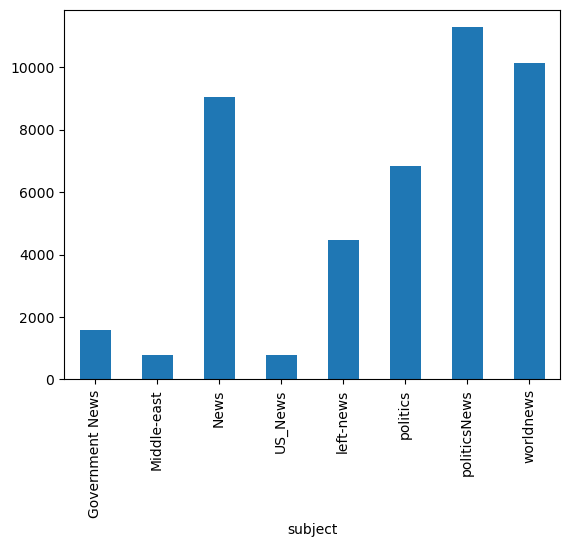

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


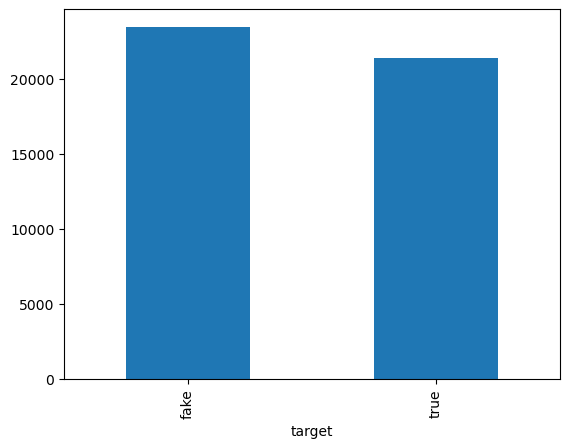

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [18]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

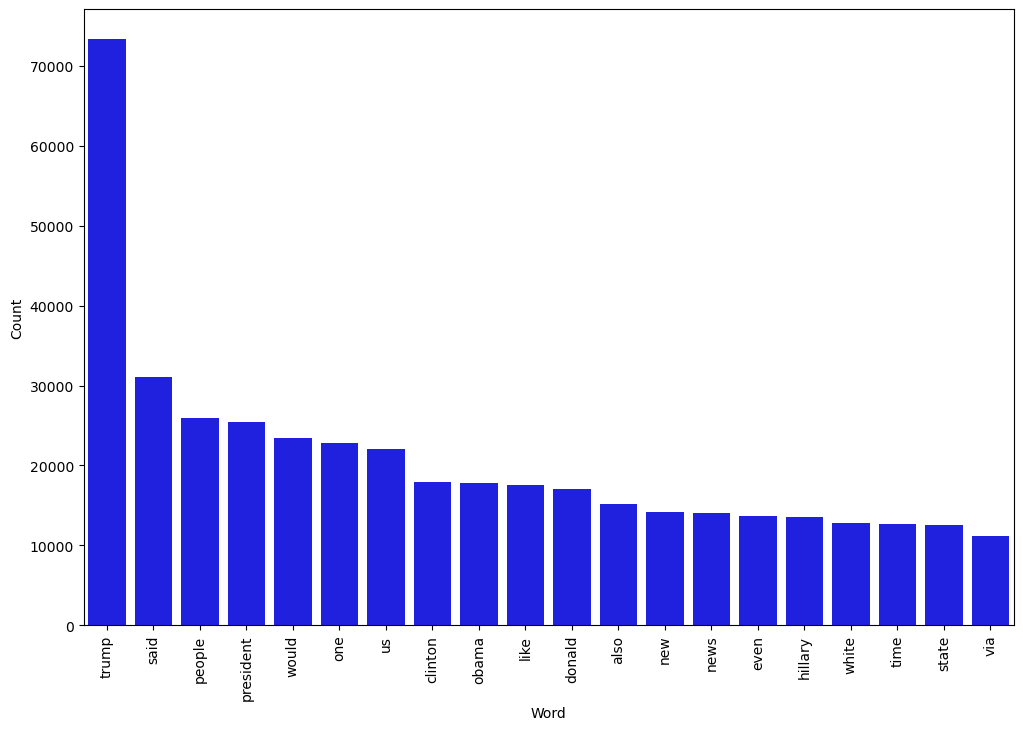

In [19]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

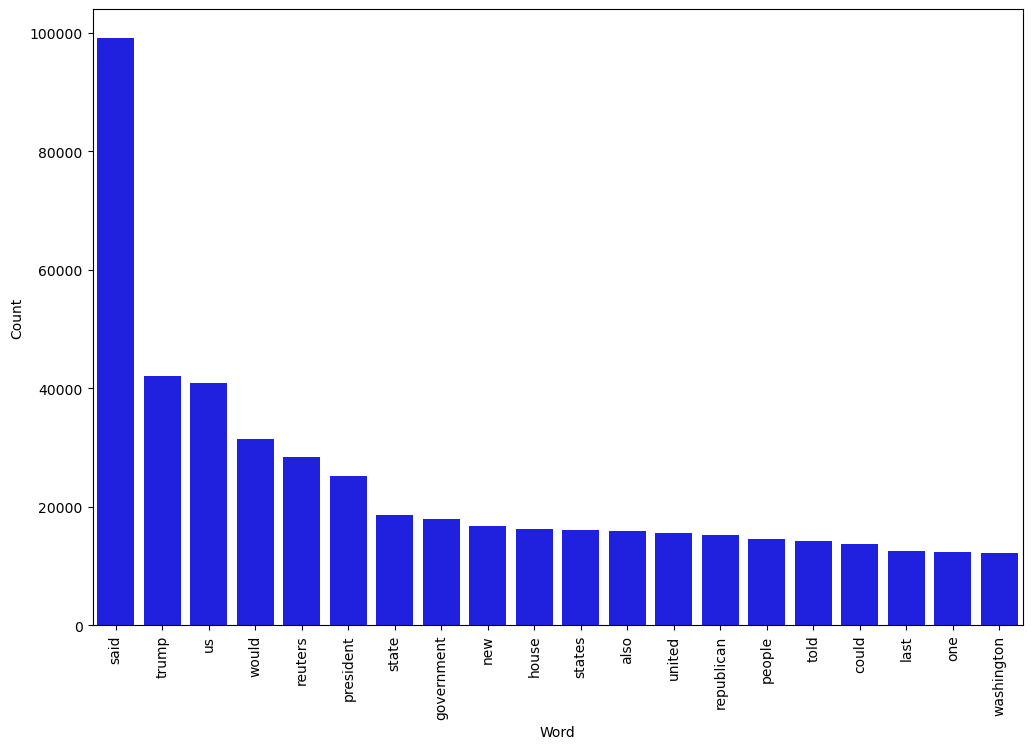

In [20]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [21]:
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [22]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

**LOGESTIC REGRESSION:**

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

In [23]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.82%


In [27]:
X_new = X_test.iloc[12]

predict = model.predict([X_new])  # Note: pass X_new as a list
print(predict)

if predict[0] == 0:
    print('The news is Real')
else:
    print('The news is Fake')


['true']
The news is Fake


**CONFUSION MATRIX:**

* The confusion matrix is a 2 dimensional array comparing predicted category labels to the true label.



Confusion matrix, without normalization


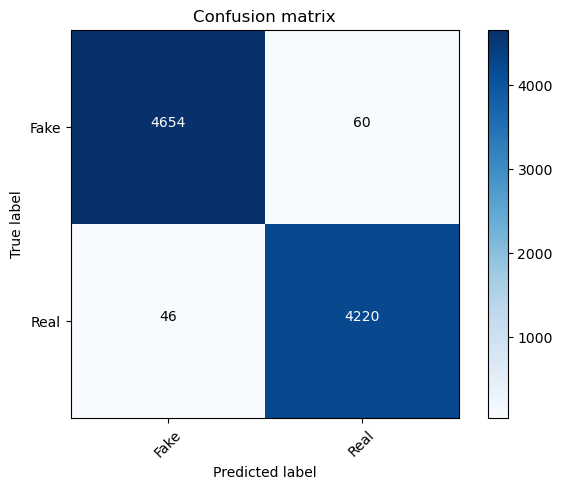

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [67]:
# Split the data
X_train1,X_test1,y_train1,y_test1 = train_test_split(data['text'], data.target, test_size=0.8, random_state=42)

In [68]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train1, y_train1)

# Accuracy
prediction1 = model.predict(X_test1)
print("accuracy: {}%".format(round(accuracy_score(y_test1, prediction1)*100,2)))

accuracy: 99.3%


In [32]:
X_new1 = X_test1.iloc[12]

predict1 = model.predict([X_new1])
print(predict1)

if (predict1[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

['true']
The news is Fake


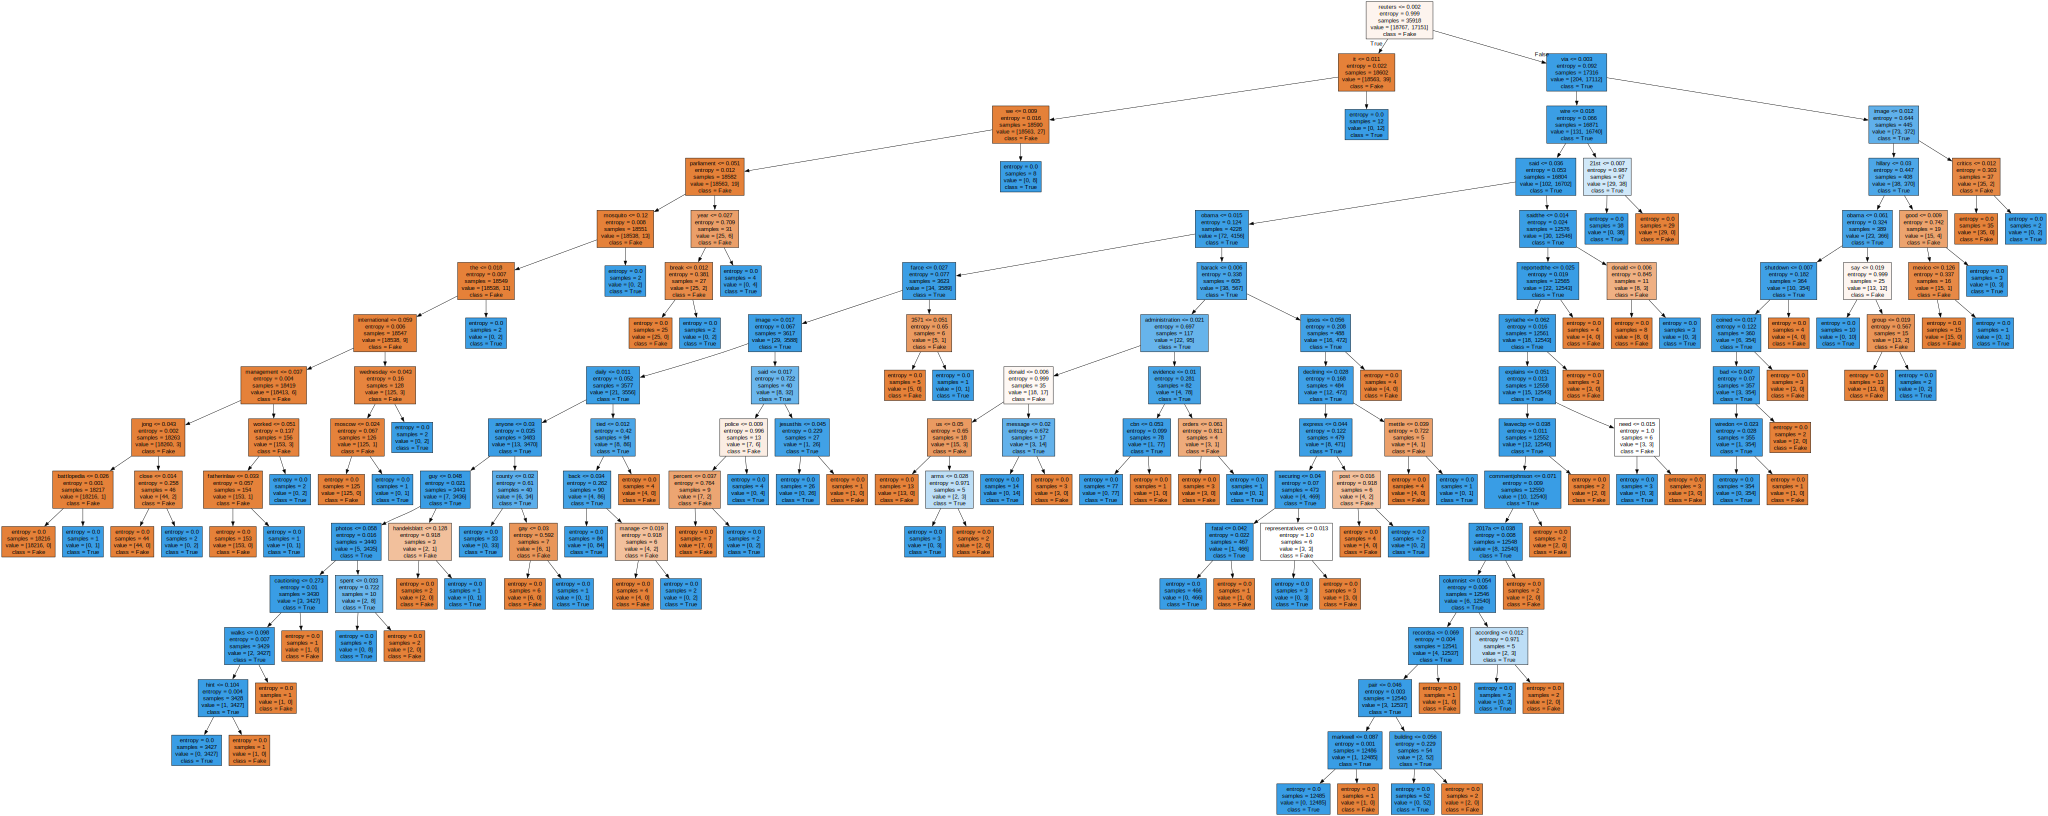

In [34]:
from sklearn.tree import export_graphviz
import graphviz

# Fitting the model
model = pipe.fit(X_train1, y_train1)

# Export the decision tree to a DOT file
export_graphviz(model.named_steps['model'], out_file='tree.dot', 
                feature_names=model.named_steps['vect'].get_feature_names_out(),
                class_names=['Fake', 'True'], filled=True)

# Visualize the decision tree using Graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)




Confusion matrix, without normalization


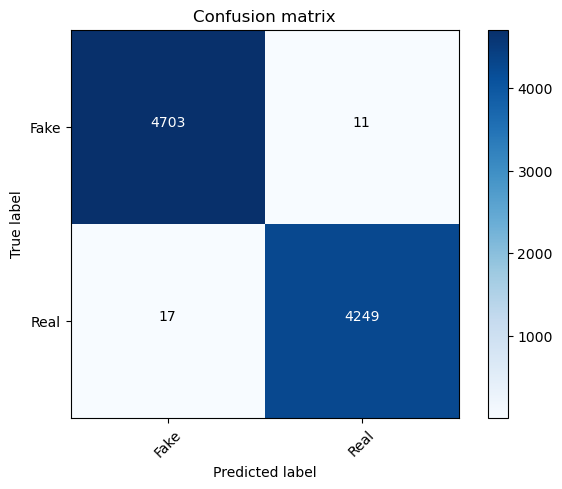

In [35]:
cm = metrics.confusion_matrix(y_test1, prediction1)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [36]:
# Split the data
X_train2,X_test2,y_train2,y_test2 = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = rf_pipe.fit(X_train2, y_train2)
prediction2 = model.predict(X_test2)
print("accuracy: {}%".format(round(accuracy_score(y_test2, prediction2)*100,2)))

accuracy: 98.78%


In [45]:
X_new2 = X_test2.iloc[12]

predict2 = model.predict([X_new2])
print(predict2)

if (predict2[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

['true']
The news is Fake


Confusion matrix, without normalization


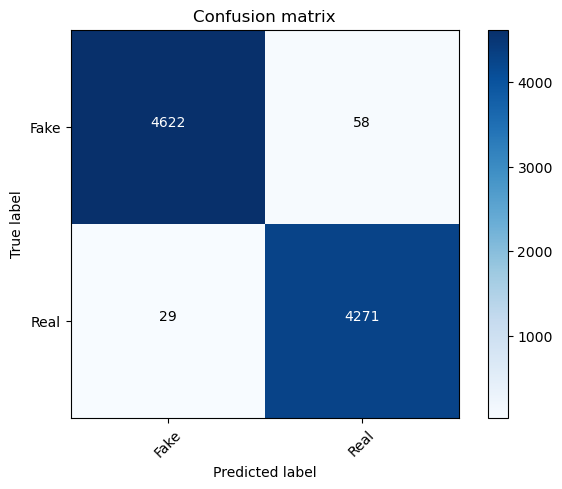

In [ ]:
cm = metrics.confusion_matrix(y_test2, prediction2)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### SVM (Support Vector Machine)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn import svm


In [40]:
# Split the data
X_train3,X_test3,y_train3,y_test3 = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [41]:
# Define SVM pipeline
svm_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.SVC(kernel='linear', C=1.0))
])

# Train SVM
svm_model = svm_pipe.fit(X_train3, y_train3)

# Make predictions on test data
prediction3 = svm_model.predict(X_test3)

# Evaluate model performance
print("\nSupport Vector Classifier:")
print("Testing Accuracy: {}".format(accuracy_score(y_test3, prediction3)))



Support Vector Classifier:
Testing Accuracy: 0.994543429844098


In [42]:
X_new3 = X_test3.iloc[12]

predict3 = model.predict([X_new3])
print(predict3)

if (predict3[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

['true']
The news is Fake


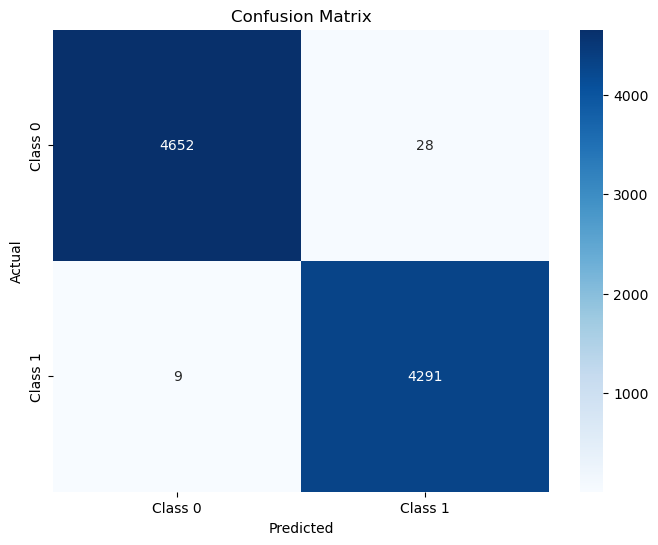

In [ ]:
cm = metrics.confusion_matrix(y_test3, prediction3)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Naive Bayes


**CLASSIFICATION MODEL :  NAIVE BAYES**

* Multinomial Naive Bayes algorithm is a probabilistic learning method that is mostly used in Natural Language Processing (NLP)

* Multinomial Naïve Bayes uses term frequency i.e. the number of times a given term appears in a document. Term frequency is often normalized by dividing the raw term frequency by the document length


In [43]:
# Split the data
X_train4,X_test4,y_train4,y_test4 = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [46]:
from sklearn.metrics import accuracy_score

# Predict using the Naive Bayes model
nb_predictions = model.predict(X_test2)

# Calculate accuracy
accuracy = accuracy_score(y_test2, nb_predictions)
print("Naive Bayes Accuracy: {:.2f}%".format(accuracy * 100))


Naive Bayes Accuracy: 98.78%


In [47]:
X_new4 = X_test4.iloc[12]

predict4 = model.predict([X_new4])
print(predict4)

if (predict4[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

['true']
The news is Fake


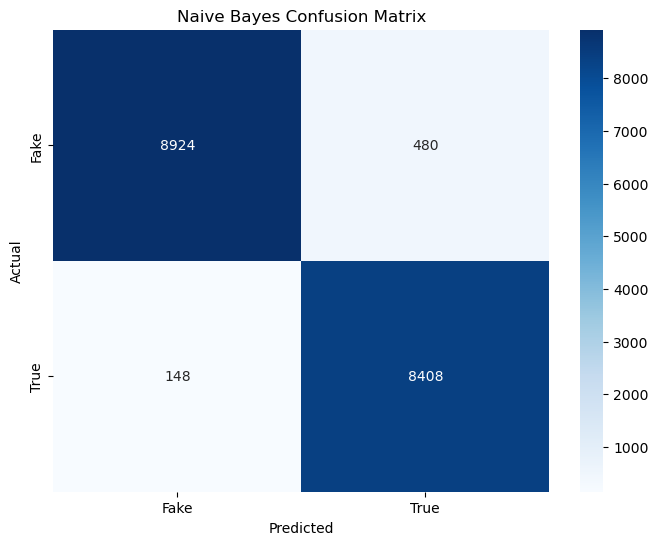

In [ ]:
cm = metrics.confusion_matrix(y_test2, nb_prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Preliminary Results :  

#### Logistic Regression 

In [48]:

from sklearn.metrics import classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, prediction)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, prediction))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, prediction))


Accuracy: 98.82%

Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4714
        true       0.99      0.99      0.99      4266

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
[[4654   60]
 [  46 4220]]


#### Decision Tree

In [69]:

from sklearn.metrics import classification_report, confusion_matrix

# Calculate accuracy
accuracy1 = accuracy_score(y_test1, prediction1)
print("Accuracy: {:.2f}%".format(accuracy1 * 100))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test1, prediction1))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test1, prediction1))


Accuracy: 99.30%

Classification Report:
              precision    recall  f1-score   support

        fake       0.99      1.00      0.99     18827
        true       0.99      0.99      0.99     17092

    accuracy                           0.99     35919
   macro avg       0.99      0.99      0.99     35919
weighted avg       0.99      0.99      0.99     35919


Confusion Matrix:
[[18736    91]
 [  162 16930]]


#### Random Forest


In [72]:

from sklearn.metrics import classification_report, confusion_matrix

# Calculate accuracy
accuracy2 = accuracy_score(y_test2, prediction2)
print("Accuracy: {:.2f}%".format(accuracy2 * 100))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test2, prediction2))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test2, prediction2))


Accuracy: 98.78%

Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4714
        true       0.98      0.99      0.99      4266

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
[[4647   67]
 [  43 4223]]


#### SVM(Support Vector Machine)

In [71]:

from sklearn.metrics import classification_report, confusion_matrix

# Calculate accuracy
accuracy3 = accuracy_score(y_test3, prediction3)
print("Accuracy: {:.2f}%".format(accuracy3 * 100))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test3, prediction3))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test3, prediction3))


Accuracy: 99.45%

Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.99      0.99      4714
        true       0.99      1.00      0.99      4266

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
[[4686   28]
 [  21 4245]]


#### Naive Bayes

In [70]:

from sklearn.metrics import classification_report, confusion_matrix

# Calculate accuracy
accuracy4 = accuracy_score(y_test4, nb_predictions)
print("Accuracy: {:.2f}%".format(accuracy4 * 100))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test4, nb_predictions))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test4, nb_predictions))


Accuracy: 98.78%

Classification Report:
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4714
        true       0.98      0.99      0.99      4266

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
[[4647   67]
 [  43 4223]]


**MODEL COMPARISON**

Hence, in this dataset we can observe that

* Logistic Regression : Accuracy is 98.82

* Decision Tree : Accuracy is 99.3

* Random Forest : Accuracy is 98.78

* SVM (Support Vector Machine) : Accuracy is 99.45 

* Naive Bayes : Accuracy is 98.78



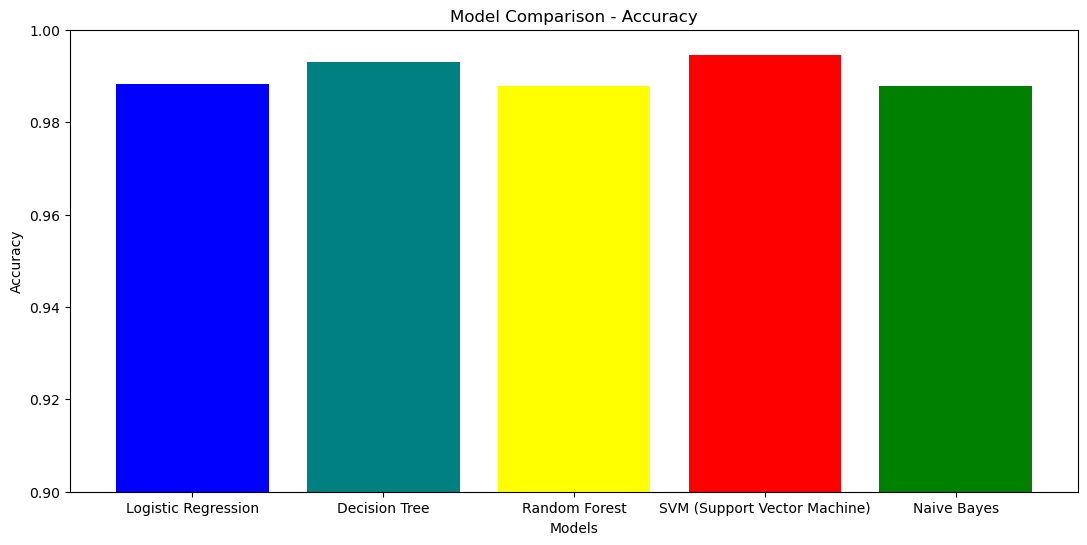

In [73]:
import matplotlib.pyplot as plt

# Define models and their accuracies
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM (Support Vector Machine)', 'Naive Bayes']
accuracies = [accuracy, accuracy1, accuracy2, accuracy3, accuracy4]

# Create bar plot
plt.figure(figsize=(13, 6))
plt.bar(models, accuracies, color=['blue', 'teal', 'yellow', 'red', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.ylim(0.9, 1.0)  # Set y-axis limits
plt.show()
